In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------
# 1. Load & prep data
# -----------------------------
df = pd.read_csv("star_wars_reviews.csv")

cols = ["fav_heroe","fav_villain","fav_soundtrack",
        "fav_spaceship","fav_planet","fav_robot"]
target = "fav_film"

X = df[cols].astype(str)
y = df[target].astype(str)

# One-hot encode for CART
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_enc = enc.fit_transform(X)

# -----------------------------
# 2. Train CART to get feature importance
# -----------------------------
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_enc, y)

importances = tree.feature_importances_
feat_names = enc.get_feature_names_out(cols)

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print("\n🌟 Top features by importance (CART):")
print(feat_imp.head(15).to_string())

# -----------------------------
# 3. Select Top Predictors
# -----------------------------
top_features = feat_imp.head(8).index
top_idx = [list(feat_names).index(f) for f in top_features]

X_top = X_enc[:, top_idx]  # reduced feature space

# Normalize for cosine geometry
Xn = normalize(X_top)

# -----------------------------
# 4. Cluster on selected features
# -----------------------------
best = None
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init=20, random_state=42).fit(Xn)
    s = silhouette_score(Xn, km.labels_, metric="cosine")
    if best is None or s > best[0]:
        best = (s, k, km)

sil, k, kmeans = best
labels = kmeans.labels_
df["cart_cluster"] = labels

print(f"\n✅ Best clustering: k={k}, silhouette(cos)={sil:.3f}")

# -----------------------------
# 5. Cluster summary
# -----------------------------
cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("\n📊 Cluster size distribution:")
print((cluster_sizes.to_frame("count")
       .assign(percent=lambda x: 100*x["count"]/len(df))
       .round(1)))

# -----------------------------
# 6. Interpret clusters: top features
# -----------------------------
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=top_features)

print("\n🔎 Top categories per cluster:")
for cid in range(k):
    print(f"\n--- Cluster {cid} (n={cluster_sizes[cid]}, {cluster_sizes[cid]/len(df)*100:.1f}%) ---")
    top = centroids.loc[cid].sort_values(ascending=False).head(5)
    for feat, val in top.items():
        cat = feat.split("_", 1)[1]  # remove prefix (fav_villain_, etc.)
        print(f"  {cat:25s}  {val:.2f}")



🌟 Top features by importance (CART):
fav_planet_Tatooine                      0.109570
fav_spaceship_TIE Fighter                0.100934
fav_villain_Darth Maul                   0.080921
fav_planet_Alderaan                      0.072361
fav_villain_Darth Vader                  0.071119
fav_soundtrack_The Throne Room           0.068996
fav_heroe_Yoda                           0.046776
fav_robot_Droideka                       0.042289
fav_spaceship_Death Star                 0.041565
fav_villain_Wilhuff Tarkin               0.041306
fav_heroe_Jar Jar Binks                  0.036701
fav_robot_R2-D2                          0.034607
fav_soundtrack_Star Wars (Main Theme)    0.031658
fav_robot_C-3PO                          0.030524
fav_soundtrack_Accross the Stars         0.027855

✅ Best clustering: k=9, silhouette(cos)=0.450

📊 Cluster size distribution:
   count  percent
0   3144      8.5
1   5829     15.8
2   9774     26.5
3   4032     10.9
4   2233      6.0
5   2942      8.0
6   2626 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


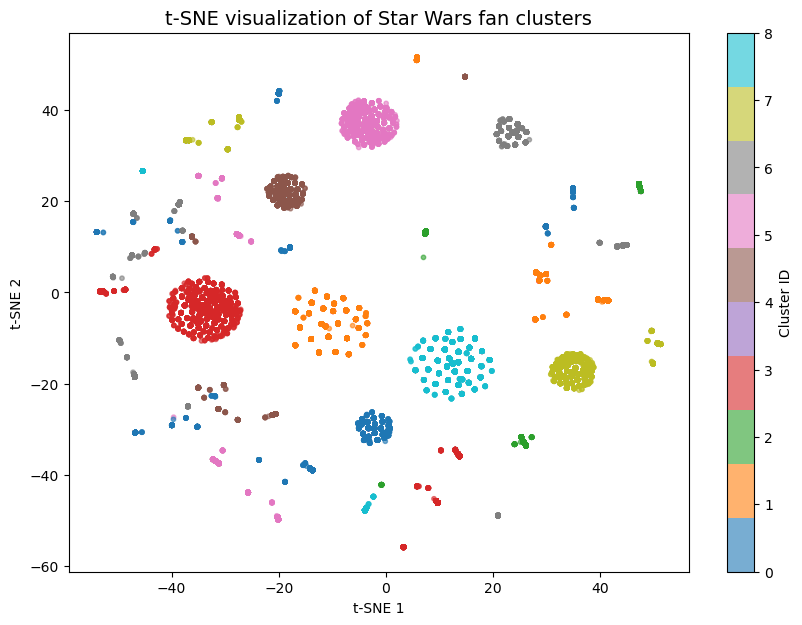

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# -----------------------------
# t-SNE projection
# -----------------------------
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200,
            random_state=42, n_iter=1000, init="random")
X_tsne = tsne.fit_transform(Xn)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10,7))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap="tab10", alpha=0.6, s=10)
plt.title("t-SNE visualization of Star Wars fan clusters", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, ticks=range(k), label="Cluster ID")
plt.show()
